In [20]:
from google.colab import files
uploaded = files.upload()

Saving data.txt to data (1).txt


In [22]:
# Import the needed modules:
from collections import deque
from graphviz import Digraph

In [33]:
class Clause:
    """Horn clause: premises imply conclusion."""

    def __init__(self, premise, conclusion):
        self.premise = set(premise)
        self.conclusion = conclusion
        self.unverified_premises = len(self.premise)  # number of premises not yet confirmed

    def decrement_count(self):
        """Reduce unverified premise count when a premise is confirmed."""
        self.unverified_premises -= 1

    def is_ready_to_conclude(self):
        """Check if all premises are confirmed."""
        return self.unverified_premises == 0

    def reset_total_unverified_premises(self):
        """Reset unverified premise count to initial value."""
        self.unverified_premises = len(self.premise)

    def __repr__(self):
        """Readable clause format."""
        return f"{' ∧ '.join(self.premise)} → {self.conclusion}"

In [34]:
class KnowledgeBase:
    """Stores facts and Horn clauses for inference."""

    def __init__(self):
        self.clauses = []  # list of Clause objects (rules)
        self.facts = set()  # known true literals

    def add_fact(self, fact):
        """Add a known fact (literal)."""
        self.facts.add(fact)

    def add_clause(self, clause):
        """Add a Horn clause (rule)."""
        self.clauses.append(clause)

    def get_clauses_with_literal_in_premise(self, literal):
        """Return clauses where 'literal' appears in the premise."""
        return [clause for clause in self.clauses if literal in clause.premise]

    def reset_unverified_premises(self):
        """Reset unverified premise counts of all clauses in KB."""
        for clause in self.clauses:
            clause.reset_total_unverified_premises()

In [35]:
class ForwardChaining:
    """Implements the forward chaining algorithm for propositional logic."""

    def __init__(self, kb):
        """
        Initialize with a knowledge base.

        Args:
            kb (KnowledgeBase): The knowledge base containing facts and clauses.
        """
        self.kb = kb
        self.agenda = deque(kb.facts)  # Queue of known facts to process
        self.inferred = {fact: False for fact in kb.facts}  # Track inferred literals
        self.used_clause = {}  # Maps inferred literals to the clause that inferred them

    def PL_FC_ENTAILS(self, q):
        """
        Determine if query q can be inferred using forward chaining.

        Args:
            q (str): The query literal to infer.

        Returns:
            bool: True if q can be inferred, False otherwise.
        """
        while self.agenda:
            p = self.agenda.popleft()

            if not self.inferred.get(p, False):
                self.inferred[p] = True

                if p == q:
                    self.print_inference_chain(q)  # Print how q was inferred
                    return True

                # For each clause that depends on p, decrement count and check if ready
                for clause in self.kb.get_clauses_with_literal_in_premise(p):
                    clause.decrement_count()
                    if clause.is_ready_to_conclude():
                        conclusion = clause.conclusion
                        if not self.inferred.get(conclusion, False):
                            self.agenda.append(conclusion)
                            self.used_clause[conclusion] = clause  # Track inference origin
        return False

    def print_inference_chain(self, q):
        """
        Print the sequence of clauses used to infer q.

        Args:
            q (str): The query literal inferred.
        """
        print(f"\n✅ Query '{q}' was inferred using these rules:")
        ordered_clauses = []
        visited = set()

        def dfs(literal):
            if literal in self.used_clause and literal not in visited:
                clause = self.used_clause[literal]
                for premise in clause.premise:
                    dfs(premise)
                ordered_clauses.append(clause)
                visited.add(literal)

        dfs(q)

        for clause in ordered_clauses:
            print(f"  -> {' ∧ '.join(clause.premise)} → {clause.conclusion}")

    def draw_inference_graph(self, query, output_file='inference_graph'):
        """
        Draw the inference graph showing how the query was inferred.

        Args:
            query (str): The query literal to visualize.
            output_file (str): The filename to save the graph image.
        """
        dot = Digraph(comment='Inference Chain')
        dot.attr(rankdir='LR')

        visited = set()
        clauses_used = []

        def dfs(literal):
            if literal in self.used_clause and literal not in visited:
                clause = self.used_clause[literal]
                for premise in clause.premise:
                    dfs(premise)
                clauses_used.append(clause)
                visited.add(literal)

        dfs(query)

        literals = set()
        for clause in clauses_used:
            literals.update(clause.premise)
            literals.add(clause.conclusion)

        # Draw literal nodes with coloring for facts
        for literal in literals:
            color = 'lightblue' if literal in self.kb.facts else 'white'
            dot.node(literal, shape='ellipse', style='filled', color=color, fontname="Arial")

        # Draw edges via joint dot nodes:
        # - edges from premises to joint node (no arrow)
        # - edge from joint node to conclusion (with arrow)
        for idx, clause in enumerate(clauses_used):
            joint_node = f'clause_{idx}'
            dot.node(joint_node, shape='point')
            for premise in clause.premise:
                dot.edge(premise, joint_node, arrowhead='none', fontname="Arial")
            dot.edge(joint_node, clause.conclusion, arrowhead='normal', fontname="Arial")

        dot.render(output_file, view=True, format='png')
        print(f"📈 Inference graph saved to '{output_file}.png' and opened for viewing.\n")

In [36]:
class Problem:
    """Handles reading a knowledge base from file and visualization."""

    def __init__(self, filename):
        """
        Initialize the problem by reading the knowledge base file.

        Args:
            filename (str): Path to the input file containing facts and rules.
        """
        self.kb = KnowledgeBase()
        self.read_file(filename)

    def read_file(self, filename):
        """
        Parse the input file line-by-line to build the knowledge base.

        Supports:
          - Facts: single positive literal
          - Rules: premises (negated literals) implying a conclusion

        Also prints the De Morgan conversion steps for each rule.

        Args:
            filename (str): Path to input file.
        """
        with open(filename, 'r') as file:
            lines = file.readlines()

        print("\n=== De Morgan Conversion for Forward Chaining Rules ===\n")

        for idx, line in enumerate(lines):
            line = line.strip()
            if not line or line.startswith('#'):
                continue

            tokens = line.split()
            head = None
            premises = []

            for tok in tokens:
                # Negated literals added to premises (strip negation symbol)
                if tok.startswith('¬') or tok.startswith('-'):
                    premises.append(tok[1:])
                else:
                    # Only one positive literal allowed per line (the conclusion)
                    if head is not None:
                        raise ValueError(f"Multiple positive literals found in line: {line}")
                    head = tok

            if head is None:
                raise ValueError(f"No positive literal found in line: {line}")

            if premises:
                # Create a rule clause with premises and conclusion
                clause = Clause(premises, head)
                self.kb.add_clause(clause)

                # Print De Morgan conversion steps
                disj = ' ∨ '.join([f"¬{p}" for p in premises] + [head])
                group_neg = f"¬({' ∧ '.join(premises)})"
                implication = f"{' ∧ '.join(premises)} → {head}"
                print(f"[Line {idx + 1}] {line}")
                print(f"  Step 1 - Disjunction:   {disj}")
                print(f"  Step 2 - De Morgan:     {head} ∨ {group_neg}")
                print(f"  Step 3 - Implication:   {implication}\n")
            else:
                # Line with only a fact (no premises)
                self.kb.add_fact(head)
                print(f"[Line {idx + 1}] {line} -> FACT: {head}\n")

    def draw_knowledge_graph(self, output_file='kb_graph'):
        """
        Draw the knowledge base graph showing facts and clauses.

        Uses joint nodes to represent clauses:
          - Premises connect to joint node (no arrow)
          - Joint node connects to conclusion (with arrow)

        Args:
            output_file (str): Filename to save the generated graph image.
        """
        dot = Digraph(comment='Knowledge Base')
        dot.attr(rankdir='LR')

        literals = set()
        for clause in self.kb.clauses:
            literals.update(clause.premise)
            literals.add(clause.conclusion)

        # Draw literal nodes; facts colored lightblue
        for literal in literals:
            if literal in self.kb.facts:
                dot.node(literal, shape='ellipse', style='filled', color='lightblue', fontname="Arial")
            else:
                dot.node(literal, shape='ellipse', fontname="Arial")

        # Draw edges via joint nodes representing clauses
        for clause in self.kb.clauses:
            joint_node = f'clause_{self.kb.clauses.index(clause)}'
            dot.node(joint_node, shape='point')
            for premise in clause.premise:
                dot.edge(premise, joint_node, arrowhead='none', fontname="Arial")
            dot.edge(joint_node, clause.conclusion, arrowhead='normal', fontname="Arial")

        dot.render(output_file, view=True, format='png')
        print(f"\n📊 Knowledge graph saved to '{output_file}.png' and opened for viewing.\n")

In [44]:
if __name__ == '__main__':
    problem = Problem('data.txt')

    while True:
      query = input("Enter your query (or 'exit' to quit): ").strip()
      if query.lower() == 'exit':
          print("Goodbye!")
          break

      forward_chaining = ForwardChaining(problem.kb)  # Khởi tạo mới mỗi lần để reset trạng thái

      result = forward_chaining.PL_FC_ENTAILS(query)
      print(f"\n🔍 Result: Can we deduce '{query}'? {result}")

      problem.draw_knowledge_graph('kb_graph')
      forward_chaining.draw_inference_graph(query, 'inference_graph')

      problem.kb.reset_unverified_premises()  # 🔁 Reset counts after each query



=== De Morgan Conversion for Forward Chaining Rules ===

[Line 1] a -b -c
  Step 1 - Disjunction:   ¬b ∨ ¬c ∨ a
  Step 2 - De Morgan:     a ∨ ¬(b ∧ c)
  Step 3 - Implication:   b ∧ c → a

[Line 2] b -d
  Step 1 - Disjunction:   ¬d ∨ b
  Step 2 - De Morgan:     b ∨ ¬(d)
  Step 3 - Implication:   d → b

[Line 3] c -e -f
  Step 1 - Disjunction:   ¬e ∨ ¬f ∨ c
  Step 2 - De Morgan:     c ∨ ¬(e ∧ f)
  Step 3 - Implication:   e ∧ f → c

[Line 4] d -g -h
  Step 1 - Disjunction:   ¬g ∨ ¬h ∨ d
  Step 2 - De Morgan:     d ∨ ¬(g ∧ h)
  Step 3 - Implication:   g ∧ h → d

[Line 5] e -a
  Step 1 - Disjunction:   ¬a ∨ e
  Step 2 - De Morgan:     e ∨ ¬(a)
  Step 3 - Implication:   a → e

[Line 6] f -b -d -h
  Step 1 - Disjunction:   ¬b ∨ ¬d ∨ ¬h ∨ f
  Step 2 - De Morgan:     f ∨ ¬(b ∧ d ∧ h)
  Step 3 - Implication:   b ∧ d ∧ h → f

[Line 7] g -c -e
  Step 1 - Disjunction:   ¬c ∨ ¬e ∨ g
  Step 2 - De Morgan:     g ∨ ¬(c ∧ e)
  Step 3 - Implication:   c ∧ e → g

[Line 8] h -f
  Step 1 - Disjunction:   ¬

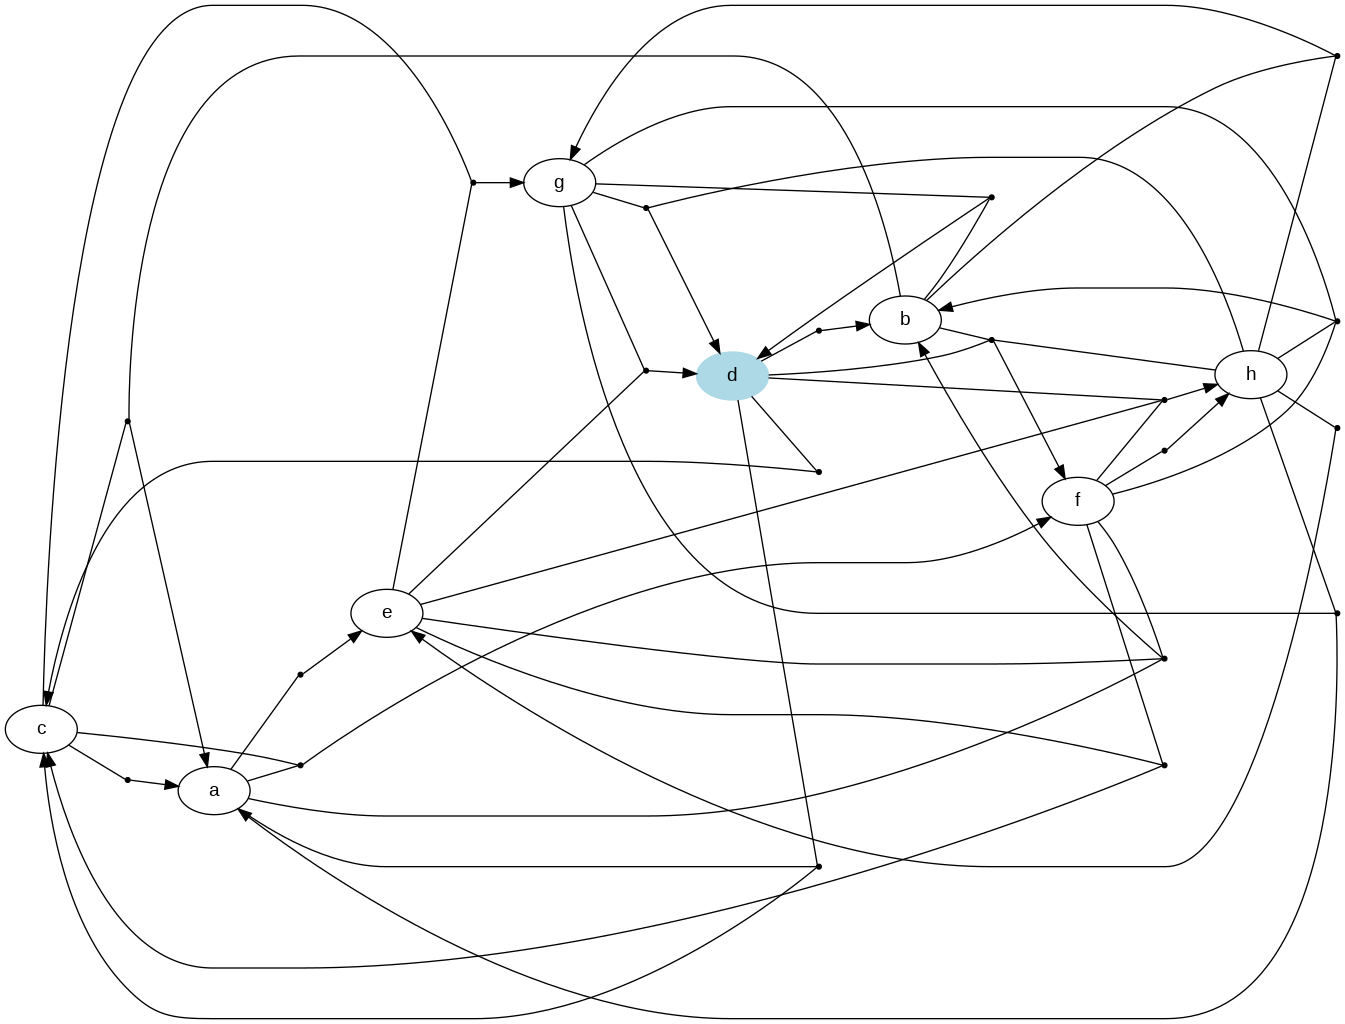

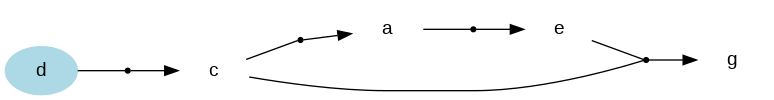

In [45]:
from IPython.display import Image, display

display(Image(filename='kb_graph.png'))
display(Image(filename='inference_graph.png'))
